In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import shap
from PIL import Image
import os
import sys

# Add the conch directory to the path if needed
!git clone https://github.com/mahmoodlab/CONCH.git /content/conch
sys.path.append("/content/conch")

# Make sure you're in the correct directory
%cd /content/drive/MyDrive/Colab Notebooks/
print(f"Current working directory: {os.getcwd()}")


Cloning into '/content/conch'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 96 (delta 38), reused 30 (delta 28), pack-reused 35 (from 1)
Receiving objects: 100% (96/96), 1.22 MiB | 5.14 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/drive/MyDrive/Colab Notebooks
Current working directory: /content/drive/MyDrive/Colab Notebooks


In [2]:
# Import modules
import datasets_utils
import model_utils
import utils
import config

# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cpu


In [3]:
# Load the model
model_name = "vit"
dataset = "oxford_pet"
CONFIG = config.get_config(model_name, dataset)

# Load the model from the specific path
model = torch.load("/content/drive/MyDrive/Colab Notebooks/model_pet.pth", map_location=CONFIG["device"])
model.eval()  # Set model to evaluation mode

print(f"Model loaded successfully: {type(model)}")

# Get the test data loader
_, _, test_loader = datasets_utils.get_data_loader(CONFIG)
print(f"Test loader created with {len(test_loader.dataset)} images")


<ipython-input-3-f9cb3d8b327a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/Colab Notebooks/model_pet.pth", map_location=CONFI

Model loaded successfully: <class 'timm.models.vision_transformer.VisionTransformer'>


100%|██████████| 218M/218M [00:01<00:00, 172MB/s]

Extracting files...


Test loader created with 2023 images


In [4]:
def nhwc_to_nchw(x):
    """Convert image from NHWC to NCHW format"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x):
    """Convert image from NCHW to NHWC format"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

# Define prediction function for SHAP explainer
def predict(img):
    """Prediction function for SHAP explainer"""
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
    return output

# Get sample images from test loader
def get_sample_images(dataloader, num_samples=5):
    """Extract sample images from the test loader"""
    samples = []
    labels = []
    paths = []

    # Get samples
    for imgs, lbls, pths in dataloader:
        for i in range(min(num_samples, len(imgs))):
            img = imgs[i].cpu()
            samples.append(img)
            labels.append(lbls[i].item())
            paths.append(pths[i])
        break

    return samples, labels, paths

In [5]:
# Define transformation functions
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transform for input images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
])

# Inverse transform for visualization
inv_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
])

# Get samples from the test loader
samples, labels, paths = get_sample_images(test_loader, num_samples=3)
print(f"Sample shape: {samples[0].shape}")
print(f"Labels: {labels}")
print(f"Paths: {paths}")

# Convert sample images to the format expected by SHAP
# First normalize them
norm_samples = [transform(img).cpu().numpy() for img in samples]

# For Oxford Pet dataset, get class names
class_names = ["dog", "cat"]  # Assuming 0 is dog, 1 is cat
print(f"Class names: {class_names}")

# Create a masker for the SHAP explainer
masker_blur = shap.maskers.Image("blur(128,128)", norm_samples[0].shape)

# Create the SHAP explainer
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# Set up SHAP parameters
topk = 2  # Number of top classes to explain (binary classification)
batch_size = 50
n_evals = 1000  # Reduced for faster computation, increase for better accuracy

Sample shape: torch.Size([3, 224, 224])
Labels: [1, 1, 1]
Paths: ['./assets/data/oxford_pet/1/test_set/test_set/cats/cat.4951.jpg', './assets/data/oxford_pet/1/test_set/test_set/cats/cat.4355.jpg', './assets/data/oxford_pet/1/test_set/test_set/cats/cat.4825.jpg']
Class names: ['dog', 'cat']


Generating SHAP values (this may take a while)...


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [37:41, 2261.03s/it]             


SHAP values shape: (1, 224, 224, 3, 2)
Visualizing SHAP values for ['cat', 'cat']


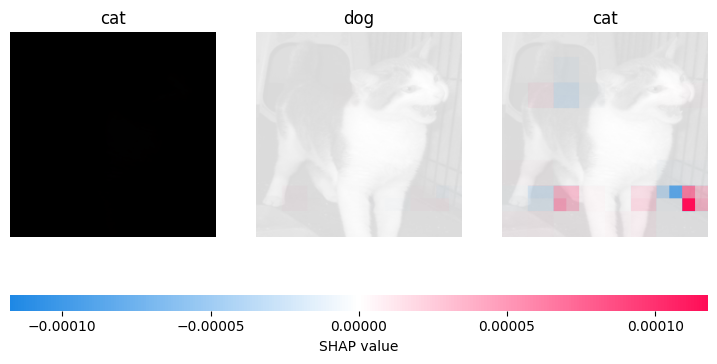

Saving summary to /content/drive/MyDrive/Colab Notebooks/shap_summary.txt
SHAP analysis complete!


In [6]:
# Generate SHAP values for the first 2 sample images
print("Generating SHAP values (this may take a while)...")
shap_values = explainer(
    np.array(norm_samples[:1]),  # Just explain 2 images to save computation time
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

print(f"SHAP values shape: {shap_values.values.shape}")

# Transform the data back for visualization
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

# Visualize the SHAP values
true_labels = [class_names[label] for label in labels[:2]]
print(f"Visualizing SHAP values for {true_labels}")

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=true_labels,
)

# Save a summary of the results
print("Saving summary to /content/drive/MyDrive/Colab Notebooks/shap_summary.txt")
with open("/content/drive/MyDrive/Colab Notebooks/shap_summary.txt", "w") as f:
    f.write(f"SHAP Explanation for {model_name} on {dataset}\\n")
    f.write("-" * 50 + "\\n")
    f.write(f"Number of images analyzed: {len(shap_values.values[0])}\\n")
    f.write(f"Classes: {class_names}\\n")
    f.write(f"True labels: {true_labels}\\n")
    f.write("\\nAnalysis complete. Check the visualization plots for detailed results.")

print("SHAP analysis complete!")

shap_summary.txt:

SHAP Explanation for vit on oxford_pet
Number of images analyzed: 1
Classes: ['dog', 'cat']
True labels: ['cat', 'cat']

Analysis complete. Check the visualization plots for detailed results.